Importing Necessary Packages

In [42]:
import pandas as pd
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation,concatenate, Attention, Bidirectional,GlobalAveragePooling1D
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import keras_tuner as kt
import math

Data Pull and Plot

In [43]:
start_date = '2016-01-01'
data = yf.download("ETH-USD", start=start_date)
data = data.reset_index()
dates = data['Date']
display(data)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
2247,2024-01-04,2210.529053,2294.608154,2204.865723,2269.038086,2269.038086,11044564896
2248,2024-01-05,2269.409424,2276.764648,2209.537109,2268.647217,2268.647217,10860953290
2249,2024-01-06,2269.540039,2271.359375,2219.781982,2241.624756,2241.624756,5970741680
2250,2024-01-07,2242.012695,2257.127930,2211.562500,2222.865967,2222.865967,6490053615


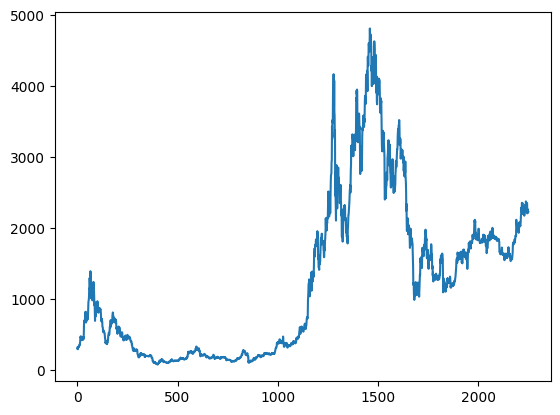

In [44]:
dataclose = data.reset_index()['Close']
plt.plot(dataclose)

In [45]:
scaler = MinMaxScaler()
dataclose = scaler.fit_transform(np.array(dataclose).reshape(-1,1))
dataclose.shape

(2252, 1)

In [46]:
train_size = int(len(dataclose)*0.65)
test_size = len(dataclose) - train_size
train_data,test_data = dataclose[0:train_size,:],dataclose[train_size:len(dataclose),:1]

In [47]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [48]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [49]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
22/22 [==============================] - 6s 106ms/step - loss: 0.0154 - val_loss: 0.0034
Epoch 2/100
22/22 [==============================] - 2s 73ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/100
22/22 [==============================] - 2s 69ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/100
22/22 [==============================] - 1s 66ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 5/100
22/22 [==============================] - 2s 77ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/100
22/22 [==============================] - 2s 101ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 8/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/100
22/22 [==============================] - 1s 66ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 10/100
22/22 [==============================] - 2s 76ms/step - loss: 0.0012 - val_loss: 0.00

In [52]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

22/22 [==============================] - 0s 16ms/step


In [53]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [54]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

1304.8537320673556
1870.3370623991773


In [55]:
look_back = 100

In [56]:
trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [57]:
testPredictPlot = np.empty_like(dataclose)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(dataclose) - 1,:] = test_predict

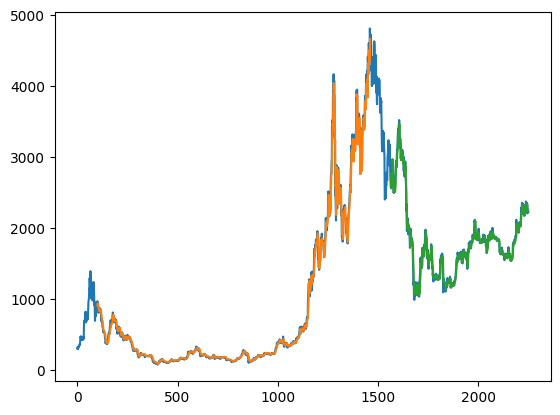

In [58]:
plt.plot(scaler.inverse_transform(dataclose))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
display()